## Lesson 05

Para este trabalho foi escolhido uma competição do kaggle [Salary-prediction-for-job-postings](https://www.kaggle.com/competitions/salary-prediction-for-job-postings/data),esta competição tinha como objetivo realizar a predição dos salarios das vagas postadas nos Estados unidos. para tal é disponibilizado um dataset com mais de 33000 amostras.

In [1633]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from pathlib import Path
from torch import tensor
torch_relu = torch.nn.ReLU()
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
path = Path('../input/salary-predition-postings')

In [1634]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

In [1635]:
df = pd.read_csv(path/'usjobs_train.csv')
df

,ID,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Frecuency_Salary,...,Skills,Sector,Sector_Group,Revenue,Employee,Company_Score,Reviews,Director,Director_Score,URL
0,job_f2c807527f687b96,"Part-time Reporting Business Analyst, Data & Analytics (Remote Position)",Financial Analyst,NaN,Remote,Sandy Hook Promise Foundation,Remote,NaN,NaN,hour,...,"['Salesforce', 'Bachelor']",NGOs and Nonprofit Organizations,Nonprofit Organizations,NaN,XS,4.2,20.0,NaN,NaN,https://www.sandyhookpromise.org/
1,job_2660d4c53505af10,Controller,Controller,NaN,NaN,Building Service 32BJ Benefit Funds,"New York, NY 10013 (Tribeca area)",New York,NY,year,...,"['SQL', 'Master', 'Dynamics 365', 'Snowflake', 'AWS', 'Qlik', 'CFA', 'Azure', 'CPA', 'Bachelor']",NGOs and Nonprofit Organizations,Nonprofit Organizations,NaN,M,3.5,58.0,"Peter Goldberger, Executive Director",0.70,NaN
2,sj_50358c44328ae06a,Sr Finance Analyst,Financial Analyst,Senior,NaN,LCS,NaN,NaN,NaN,year,...,"['Word', 'Bachelor', 'Excel']",Personal Consumer Services,Sales,XXXS,XXXS,3.4,88.0,NaN,NaN,NaN
3,job_a087fd700e3e85f0,Senior Business Intelligence Analyst,Business Intelligence,Senior,Hybrid,Federal Reserve Bank of Richmond,"Richmond, VA 23219 (Central Office area)",Richmond,VA,year,...,"['PowerPoint', 'Power BI', 'Tableau', 'Word', 'Excel', 'Bachelor', 'Office']",Banking and Credit Services,Finance,XXL,XL,3.8,30.0,Tom Barkin,0.70,https://www.richmondfed.org/
4,job_d2a2538a2c4d2033,Data Center Operations Analyst (Temporary Assignment),Operations Analyst,NaN,Remote,Los Angeles County Office of Education,"Downey, CA 90242+1 ubicación",Downey,CA,hour,...,['Office'],State and Regional Agencies,Government,NaN,XL,4.2,186.0,Debra Duardo,0.85,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33243,job_51375f2d25e41629,Accounting Specialist I - Treasurer (Prescott),Finance,NaN,NaN,Yavapai County Human Resources,"Prescott, AZ",Prescott,AZ,year,...,"['English', 'Office']",Government and Public Administration,Government,NaN,XL,3.6,38.0,NaN,NaN,http://www.yavapai.us/
33244,job_af259ef51491c1fd,Treasurer Accounting Supervisor (Department Promotion Only),Finance,NaN,NaN,Pinal County,"Florence, AZ 85132",Florence,AZ,year,...,"['CPA', 'Office', 'Bachelor']",Government and Public Administration,Government,NaN,NaN,3.3,30.0,NaN,NaN,NaN
33245,job_45519b91f601ab4c,FINANCIAL MANAGEMENT ANALYST,Financial Analyst,NaN,NaN,US Naval Air Systems Command,"Patuxent River, MD+1 ubicación",Patuxent River,MD,year,...,"['Office', 'Bachelor']",Government and Public Administration,Government,XL,XL,4.3,4586.0,NaN,NaN,https://www.secnav.navy.mil/donhr/Pages/Default.aspx
33246,job_25a66c0757505368,BA with Management of Change,Business Analyst,NaN,NaN,Source Mantra,"Houston, TX 77015",Houston,TX,hour,...,['SQL'],IT Support,Information Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1636]:
df.isna().sum()

ID                      0
Job                     0
Jobs_Group              0
Profile             21107
Remote              19319
Company                 9
Location               13
City                 3824
State                3112
Frecuency_Salary        0
Mean_Salary             0
Skills                  0
Sector               7214
Sector_Group         7214
Revenue             18318
Employee            12799
Company_Score        8762
Reviews              8762
Director            20785
Director_Score      21924
URL                 16033
dtype: int64

<AxesSubplot:>

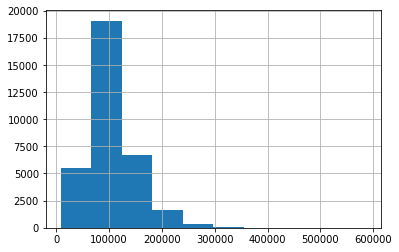

In [1637]:
df["Mean_Salary"].hist()

Como é possivel ver pelo grafico acima, o dado de salario já se encontra padronizado para salarios anuais.de modo que a coluna de Frequency salary se torna ineficiente para o treinamento do modelo.

In [1638]:
df.describe(include=(np.number))

,Mean_Salary,Company_Score,Reviews,Director_Score
count,33248.000000,24486.000000,24486.000000,11324.000000
mean,104938.652004,3.659287,2724.875398,0.748707
std,43891.461738,0.629555,13336.396863,0.110831
min,9200.000000,1.000000,1.000000,0.060000
25%,75000.000000,3.400000,13.000000,0.680000
50%,96600.000000,3.700000,117.000000,0.780000
75%,125000.000000,4.000000,960.000000,0.830000
max,585000.000000,5.000000,247915.000000,1.000000


Here's how we get a quick summary of all the non-numeric columns in the dataset:

In [1639]:
df.describe(include=[object])

,ID,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Frecuency_Salary,Skills,Sector,Sector_Group,Revenue,Employee,Director,URL
count,33248,33248,33248,12141,13929,33239,33235,29424,30136,33248,33248,26034,26034,14930,20449,12463,17215
unique,33248,17227,14,3,2,13995,12542,2951,54,5,10805,138,28,9,9,2613,5147
top,job_f2c807527f687b96,Controller,Financial Analyst,Senior,Remote,Booz Allen Hamilton,Remote,New York,CA,year,['Bachelor'],Healthcare,Information Technology,XXXL,XXXL,Jamie Dimon,http://www.boozallen.com/
freq,1,1132,5453,6021,10578,233,2223,1986,5644,26981,1777,2403,4358,4245,7976,234,233


In [1640]:
def clean_city_and_state(df):
    def extract_city(location):
        if pd.notna(location) and ',' in location:
            parts = location.split(', ')
            return parts[0]  # First part is the city
        elif location == 'R':
            return 'Remote'
        return None

    def extract_state(location):
        if pd.notna(location) and ',' in location:
            parts = location.split(', ')
            if len(parts) >= 2:
                return parts[1]  # Second part is the state
            else:
                return 'Remote'
        elif location == 'R':
            return 'Remote'
        return None

    df['Remote'] = df['Remote'].fillna(df['Location'].apply(lambda x: 'R' if 'Remote' in str(x) else 'P')).map({'Remote': 'R', 'Hybrid': 'H', 'P': 'P'})
    df.loc[(df['Remote'] == 'R') & df['Location'].isna(), 'Location'] = 'Remote'

    df['City'] = df.apply(lambda row: extract_city(row['Location']) if pd.isna(row['City']) or (pd.isna(row['Location']) and row['City'] is None) else row['City'], axis=1)
    df['State'] = df.apply(lambda row: extract_state(row['Location']) if pd.isna(row['State']) or (pd.isna(row['Location']) and row['State'] is None) else row['State'], axis=1)

    df['City'] = df['City'].combine_first(df['Location'])
    df['State'] = df['State'].combine_first(df['Location'])


In [1641]:
clean_city_and_state(df)
df.isna().sum()

ID                      0
Job                     0
Jobs_Group              0
Profile             21107
Remote                  0
Company                 9
Location                8
City                    8
State                   8
Frecuency_Salary        0
Mean_Salary             0
Skills                  0
Sector               7214
Sector_Group         7214
Revenue             18318
Employee            12799
Company_Score        8762
Reviews              8762
Director            20785
Director_Score      21924
URL                 16033
dtype: int64

In [1642]:
def fill_nan_and_remove_some_data(df):
    min_values = {
        'Profile': 'Junior',
        'Director_Score': df['Director_Score'].mean(),
        'Company_Score': df['Company_Score'].mean(),
        'Reviews': 0,
        'Employee': 'P',
        'Revenue': 'P',
        'Sector': 'Not informed',
        'Sector_Group': 'Not informed',
        'Company': 'Not informed'
    }

    for column, value in min_values.items():
        df[column] = df[column].fillna(value)

    df.drop(['Director', 'URL', 'Frecuency_Salary', 'ID'], axis=1, inplace=True)

In [1643]:
fill_Nan_and_remove_some_data(df)
df[df.isna().any(axis=1)]

,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Mean_Salary,Skills,Sector,Sector_Group,Revenue,Employee,Company_Score,Reviews,Director_Score
2,Sr Finance Analyst,Financial Analyst,Senior,P,LCS,NaN,NaN,NaN,84500.0,"['Word', 'Bachelor', 'Excel']",Personal Consumer Services,Sales,XXXS,XXXS,3.4,88.0,0.748707
2241,Data Engineer I,Data Engineer,Junior,P,Kforce,NaN,NaN,NaN,96600.0,"['SSIS', 'SQL', 'Teradata']",Business Consulting,Consulting,XL,XXXL,3.8,1878.0,0.810000
11166,Business Analyst,Business Analyst,Junior,P,Macquarie Group Limited,NaN,NaN,NaN,119000.0,['PowerPoint'],Finance,Finance,XXXL,XXXL,3.8,242.0,0.840000
13449,Interim Accounting Manager,Finance,Lead,P,Conexus,NaN,NaN,NaN,138000.0,"['CPA', 'Bachelor']",Community Services,Government,XS,XS,3.7,27.0,0.748707
19234,Controller,Controller,Junior,P,OnTrack Rogue Valley,NaN,NaN,NaN,80000.0,"['MBA', 'Excel', 'CPA', 'Bachelor', 'Office']",Healthcare,Health,P,S,3.2,15.0,0.748707
20421,Controller,Controller,Junior,H,High Country Search Group,NaN,NaN,NaN,125000.0,"['Excel', 'Office', 'Master', 'ERP']",Human Resources,Human Resources,XS,XS,4.6,26.0,0.748707
27310,"Assistant Accounting Manager - CPA, Japanese Bilingual preferred",Business Intelligence,Lead,H,"Pasona N A, Inc.",NaN,NaN,NaN,119000.0,"['PowerPoint', 'Power BI', 'Japanese', 'Excel', 'CPA', 'SAP', 'Bachelor', 'Office']",Human Resources Consulting,Human Resources,S,S,4.0,45.0,0.880000
31127,Assistant Controller,Controller,Junior,P,Owen Electric,NaN,NaN,NaN,56120.0,['Office'],Electricity and Public Utilities,Government,S,S,3.2,53.0,0.748707


In [1644]:
df = df.dropna()

In [1645]:
df.isna().sum()

Job               0
Jobs_Group        0
Profile           0
Remote            0
Company           0
Location          0
City              0
State             0
Mean_Salary       0
Skills            0
Sector            0
Sector_Group      0
Revenue           0
Employee          0
Company_Score     0
Reviews           0
Director_Score    0
dtype: int64

Now we can create our independent (predictors) and dependent (target) variables. They both need to be PyTorch tensors. Our dependent variable is `Survived`:

In [1646]:
from torch import tensor

df.sort_values(by=list(df.columns),inplace=True)
t_dep = tensor(df['Mean_Salary'].values, dtype=torch.float)
df.head()

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Mean_Salary,Skills,Sector,Sector_Group,Revenue,Employee,Company_Score,Reviews,Director_Score
28713,"""IT-Tech Support Analyst/27/TEC214 ITSM Data & Reporting Analyst""",Financial Analyst,Junior,R,Azzurra Solutions LLC,Remote,Remote,Remote,54832.0,['DOMO'],IT Support,Information Technology,P,P,3.659287,0.0,0.748707
16334,#10657 - Salesforce Business Analyst,Business Analyst,Junior,P,Qualitest,"Bridgewater, NJ+1 ubicación",Bridgewater,NJ,90000.0,['Salesforce'],Machinery Manufacturing,Product Manufacturing,M,XL,3.200000,30.0,0.748707
15957,#10899 - Data Collection Technician,Data Analyst,Junior,P,Qualitest,"Burlingame, CA+1 location",Burlingame,CA,38640.0,"['Excel', 'Google Sheets', 'Office', 'Machine Learning', 'Artificial Intelligence']",Machinery Manufacturing,Product Manufacturing,M,XL,3.200000,30.0,0.748707
21169,#23-057 Director of Financial Services & Controller,Controller,Lead,P,Arizona Western College,United States,United States,United States,98090.0,"['Office', 'Master', 'Bachelor']",Education,Education,XXXS,XXXS,4.300000,90.0,0.748707
13362,"#304 - Senior Strategic IT Solutions Architect - (AWS, Big Data, AI/ML)",Business Intelligence,Senior,R,"Next Phase Solutions and Services, Inc.","Columbia, MD 21044",Columbia,MD,210000.0,"['Master', 'AWS', 'Azure', 'Bachelor', 'Office', 'Machine Learning', 'Artificial Intelligence']",Information Technology,Information Technology,XS,S,5.000000,2.0,0.748707


In [1647]:
t_dep

tensor([ 54832.0000,  90000.0000,  38640.0000,  98090.0000, 210000.0000, 138000.0000, 110400.0000,  ..., 167734.4062, 197800.0000,
         48300.0000, 125000.0000, 188000.0000, 224000.0000,  83959.2031])

In [1648]:
numeric_indep_cols = ['Company_Score', 'Reviews']
string_indep_cols = ['Job', 'Jobs_Group', 'Profile', 'Remote', 'Company', 'Location', 'City', 'State', 'Skills', 'Sector', 'Sector_Group']
indep_cols = numeric_indep_cols + string_indep_cols

numeric_df = pd.DataFrame(df[numeric_indep_cols])
for col in string_indep_cols:
    mapping = {value: idx for idx, value in enumerate(df[col].astype('category').cat.categories)}
    mapping_reduced_values = {value: idx/1000 for idx, value in enumerate(df[col].astype('category').cat.categories)}
    
    numeric_df[col] = df[col].map(mapping)

t_indep = tensor(numeric_df.values, dtype=torch.float)

In [1649]:
numeric_df.describe()

,Company_Score,Reviews,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Skills,Sector,Sector_Group
count,33240.000000,33240.000000,33240.000000,33240.000000,33240.000000,33240.000000,33240.000000,33240.000000,33240.000000,33240.000000,33240.000000,33240.000000,33240.000000
mean,3.659274,2007.187876,7729.018742,5.402948,0.535469,1.217479,7040.328309,6627.775241,1654.569976,34.819013,4581.608484,69.054483,13.695006
std,0.540288,11509.045345,4925.284820,3.417467,0.781649,0.609670,4061.097887,3552.062910,915.914814,29.452431,3490.123510,31.568817,5.999714
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.500000,0.000000,3611.000000,2.000000,0.000000,1.000000,3449.000000,3484.750000,780.000000,8.000000,1498.750000,55.000000,10.000000
50%,3.659287,25.000000,7308.500000,5.000000,0.000000,1.000000,7086.500000,7336.000000,1926.000000,29.000000,3115.000000,65.000000,13.000000
75%,3.900000,434.000000,12093.250000,9.000000,1.000000,2.000000,10760.250000,9330.000000,2391.000000,43.000000,7861.000000,87.000000,18.000000
max,5.000000,247915.000000,17225.000000,13.000000,2.000000,2.000000,13991.000000,12541.000000,3192.000000,99.000000,10801.000000,138.000000,28.000000


In [1650]:
mask_nan = torch.isnan(t_indep)
num_nan = torch.sum(mask_nan).item()
t_indep = t_indep / t_indep.max(dim=0).values

Here's the number of rows and columns we have for our independent variables:

In [1651]:
t_indep.shape

torch.Size([33240, 13])

## Setting up a linear model

In [1652]:
torch.manual_seed(45)

n_coeff = t_indep.shape[1]
coeffs = torch.rand(n_coeff)-0.02
coeffs

tensor([0.1669, 0.9413, 0.6634, 0.8788, 0.0305, 0.5355, 0.7661, 0.0366, 0.7642, 0.1280, 0.0188, 0.0837, 0.4016])

Our predictions will be calculated by multiplying each row by the coefficients, and adding them up. One interesting point here is that we don't need a separate constant term (also known as a "bias" or "intercept" term), or a column of all `1`s to give the same effect has having a constant term. That's because our dummy variables already cover the entire dataset -- e.g. there's a column for "male" and a column for "female", and everyone in the dataset is in exactly one of these; therefore, we don't need a separate intercept term to cover rows that aren't otherwise part of a column.

Here's what the multiplication looks like:

In [1653]:
t_indep*coeffs

tensor([[    0.1222,     0.0000,     0.0000,     0.6084,     0.0000,     0.5355,     0.0654,     0.0267,     0.5571,     0.0556,     0.0017,
             0.0382,     0.1865],
        [    0.1068,     0.0001,     0.0000,     0.0676,     0.0000,     0.2677,     0.5244,     0.0044,     0.0711,     0.0427,     0.0169,
             0.0461,     0.3012],
        [    0.1068,     0.0001,     0.0001,     0.3380,     0.0000,     0.2677,     0.5244,     0.0049,     0.0804,     0.0065,     0.0033,
             0.0461,     0.3012],
        [    0.1436,     0.0003,     0.0001,     0.2704,     0.0153,     0.2677,     0.0532,     0.0339,     0.6914,     0.1034,     0.0052,
             0.0225,     0.0717],
        [    0.1669,     0.0000,     0.0002,     0.1352,     0.0305,     0.5355,     0.4535,     0.0075,     0.1317,     0.0284,     0.0046,
             0.0394,     0.1865],
        [    0.1369,     0.0074,     0.0002,     0.7436,     0.0000,     0.5355,     0.0274,     0.0197,     0.4120,     0.01

We can see we've got a problem here. The sums of each row will be dominated by the first column, which is `Age`, since that's bigger on average than all the others.

Let's make all the columns contain numbers from `0` to `1`, by dividing each column by its `max()`:

In [1654]:
vals,indices = t_indep.max(dim=0)
t_indep = t_indep / vals

As we see, that removes the problem of one column dominating all the others:

In [1655]:
t_indep*coeffs

tensor([[    0.1222,     0.0000,     0.0000,     0.6084,     0.0000,     0.5355,     0.0654,     0.0267,     0.5571,     0.0556,     0.0017,
             0.0382,     0.1865],
        [    0.1068,     0.0001,     0.0000,     0.0676,     0.0000,     0.2677,     0.5244,     0.0044,     0.0711,     0.0427,     0.0169,
             0.0461,     0.3012],
        [    0.1068,     0.0001,     0.0001,     0.3380,     0.0000,     0.2677,     0.5244,     0.0049,     0.0804,     0.0065,     0.0033,
             0.0461,     0.3012],
        [    0.1436,     0.0003,     0.0001,     0.2704,     0.0153,     0.2677,     0.0532,     0.0339,     0.6914,     0.1034,     0.0052,
             0.0225,     0.0717],
        [    0.1669,     0.0000,     0.0002,     0.1352,     0.0305,     0.5355,     0.4535,     0.0075,     0.1317,     0.0284,     0.0046,
             0.0394,     0.1865],
        [    0.1369,     0.0074,     0.0002,     0.7436,     0.0000,     0.5355,     0.0274,     0.0197,     0.4120,     0.01

One thing you hopefully noticed is how amazingly cool this line of code is:

    t_indep = t_indep / vals

That is dividing a matrix by a vector -- what on earth does that mean?!? The trick here is that we're taking advantage of a technique in numpy and PyTorch (and many other languages, going all the way back to APL) called [broadcasting](https://numpy.org/doc/stable/user/basics.broadcasting.html). In short, this acts as if there's a separate copy of the vector for every row of the matrix, so it divides each row of the matrix by the vector. In practice, it doesn't actually make any copies, and does the whole thing in a highly optimized way, taking full advantage of modern CPUs (or, indeed, GPUs, if we're using them). Broadcasting is one of the most important techniques for making your code concise, maintainable, and fast, so it's well worth studying and practicing.

We can now create predictions from our linear model, by adding up the rows of the product:

In [1656]:
preds = (t_indep*coeffs).sum(axis=1)

In [1657]:
preds

tensor([2.1972, 1.4491, 1.6796, 1.6787, 1.7199, 2.0433, 1.8746,  ..., 3.2581, 2.6523, 3.3951, 3.1574, 2.5377, 2.5366, 2.2101])

In [1658]:
preds[:10]

tensor([2.1972, 1.4491, 1.6796, 1.6787, 1.7199, 2.0433, 1.8746, 2.2880, 1.8048, 1.3680])

Of course, these predictions aren't going to be any use, since our coefficients are random -- they're just a starting point for our gradient descent process.

To do gradient descent, we need a loss function. Taking the average error of the rows (i.e. the absolute value of the difference between the prediction and the dependent) is generally a reasonable approach:

In [1659]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(104937.0781)

Now that we've tested out a way of calculating predictions, and loss, let's pop them into functions to make life easier:

In [1660]:
def calc_preds(coeffs, indeps): return (indeps*coeffs).sum(axis=1)
def calc_loss(coeffs, indeps, deps): return torch.abs(calc_preds(coeffs, indeps)-deps).mean()

## Training the linear model

Before we begin training our model, we'll need to ensure that we hold out a validation set for calculating our metrics (for details on this, see "[Getting started with NLP for absolute beginners](https://www.kaggle.com/code/jhoward/getting-started-with-nlp-for-absolute-beginners#Test-and-validation-sets)".

There's lots of different ways we can do this. In the next notebook we'll be comparing our approach here to what the fastai library does, so we'll want to ensure we split the data in the same way. So let's use `RandomSplitter` to get indices that will split our data into training and validation sets:

In [1661]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=545)(df)

Now we can apply those indicies to our independent and dependent variables:

In [1662]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]
len(trn_indep),len(val_indep)

(26592, 6648)

We'll create functions for the three things we did manually above: updating `coeffs`, doing one full gradient descent step, and initilising `coeffs` to random numbers:

In [1663]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [1664]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad(): update_coeffs(coeffs, lr)
    print(f"{loss:.3f}", end="; ")

In [1665]:
def init_coeffs(): return (torch.rand(n_coeff)-0.2).requires_grad_()

We can now use these functions to train our model:

In [1666]:
def train_model(epochs=500, lr=1210):
    torch.manual_seed(700)
    coeffs = init_coeffs()
    for i in range(epochs): one_epoch(coeffs, lr=lr)
    return coeffs

Let's try it. Our loss will print at the end of every step, so we hope we'll see it going down:

In [1667]:
coeffs = train_model(700, lr=1200)

105020.422; 101480.570; 97940.711; 94400.945; 90863.180; 87329.242; 83800.953; 80280.062; 76780.898; 73320.727; 69918.820; 66595.758; 63363.465; 60267.879; 57318.625; 54549.656; 51981.406; 49627.340; 47478.160; 45541.840; 43825.199; 42321.383; 41025.414; 39915.152; 38971.590; 38165.629; 37474.035; 36881.652; 36375.777; 35945.570; 35582.242; 35269.527; 35007.344; 34783.062; 34592.773; 34432.676; 34295.363; 34176.996; 34075.359; 33985.977; 33908.832; 33843.938; 33787.621; 33737.785; 33694.562; 33656.719; 33623.984; 33596.234; 33572.102; 33550.980; 33532.387; 33516.129; 33501.590; 33488.289; 33476.105; 33464.816; 33454.223; 33444.359; 33435.336; 33426.965; 33419.027; 33411.355; 33403.984; 33396.941; 33390.172; 33383.672; 33377.363; 33371.285; 33365.289; 33359.406; 33353.629; 33347.945; 33342.336; 33336.762; 33331.262; 33325.832; 33320.469; 33315.180; 33309.969; 33304.820; 33299.715; 33294.688; 33289.723; 33284.809; 33279.926; 33275.082; 33270.242; 33265.422; 33260.621; 33255.863; 33251.12

It does!

Let's take a look at the coefficients for each column:

In [1668]:
def show_coeffs(): return dict(zip(indep_cols, coeffs.requires_grad_(False)))
show_coeffs()

{'Company_Score': tensor(49772.1367),
 'Reviews': tensor(2179.9817),
 'Job': tensor(15293.8223),
 'Jobs_Group': tensor(8049.4497),
 'Profile': tensor(22332.8047),
 'Remote': tensor(12696.4141),
 'Company': tensor(9174.5010),
 'Location': tensor(11131.1582),
 'City': tensor(9920.8828),
 'State': tensor(5514.2339),
 'Skills': tensor(10156.2256),
 'Sector': tensor(11382.9473),
 'Sector_Group': tensor(16108.7334)}

## Measuring accuracy

The Kaggle competition is not, however, scored by absolute error (which is our loss function). It's scored by *accuracy* -- the proportion of rows where we correctly predict survival. Let's see how accurate we were on the validation set. First, calculate the predictions:

In [1669]:
preds = calc_preds(coeffs, val_indep)

In [1670]:
error = abs(val_dep-(preds))
error[:15]

tensor([34352.2422,   306.3984, 25288.5781, 21248.7656, 25081.3359, 61709.3828,  1861.3125, 42566.2969, 59515.6016, 25949.3594, 13788.1328,
        58387.7969, 45830.3516, 57873.3594, 14145.0391])

Let's see what our average accuracy is:

In [1671]:
error.float().mean()

tensor(31956.9727)

That's not a bad start at all! We'll create a function so we can calcuate the accuracy easy for other models we train:

In [1672]:
def acc(coeffs): return (val_dep-(calc_preds(coeffs, val_indep))).float().mean()
acc(coeffs)

tensor(9158.5068)

In [1673]:
preds[:28]

tensor([106202.2422, 117806.3984, 112321.4219,  98001.2344, 100581.3359,  80790.6172,  89142.8125,  87023.7031, 112984.3984,  85949.3594,
         88211.8672,  71612.2031,  82630.3516, 103873.3594,  79145.0391, 125684.3281,  88961.7266,  83161.8750, 115920.5469, 126326.2891,
        102937.7734, 103281.1406,  79921.2578, 112251.7188, 111291.6484, 104952.4766, 100525.8125,  71776.6875])

Let's train a new model now, using this updated function to calculate predictions:

In [1674]:
coeffs = train_model(lr=1200)

105020.422; 101480.570; 97940.711; 94400.945; 90863.180; 87329.242; 83800.953; 80280.062; 76780.898; 73320.727; 69918.820; 66595.758; 63363.465; 60267.879; 57318.625; 54549.656; 51981.406; 49627.340; 47478.160; 45541.840; 43825.199; 42321.383; 41025.414; 39915.152; 38971.590; 38165.629; 37474.035; 36881.652; 36375.777; 35945.570; 35582.242; 35269.527; 35007.344; 34783.062; 34592.773; 34432.676; 34295.363; 34176.996; 34075.359; 33985.977; 33908.832; 33843.938; 33787.621; 33737.785; 33694.562; 33656.719; 33623.984; 33596.234; 33572.102; 33550.980; 33532.387; 33516.129; 33501.590; 33488.289; 33476.105; 33464.816; 33454.223; 33444.359; 33435.336; 33426.965; 33419.027; 33411.355; 33403.984; 33396.941; 33390.172; 33383.672; 33377.363; 33371.285; 33365.289; 33359.406; 33353.629; 33347.945; 33342.336; 33336.762; 33331.262; 33325.832; 33320.469; 33315.180; 33309.969; 33304.820; 33299.715; 33294.688; 33289.723; 33284.809; 33279.926; 33275.082; 33270.242; 33265.422; 33260.621; 33255.863; 33251.12

The loss has improved by a lot. Let's check the accuracy:

In [1675]:
acc(coeffs)

tensor(9129.1543, grad_fn=<MeanBackward0>)

That's improved too! Here's the coefficients of our trained model:

In [1676]:
show_coeffs()

{'Company_Score': tensor(43464.5508),
 'Reviews': tensor(1650.4135),
 'Job': tensor(16174.3867),
 'Jobs_Group': tensor(9588.5088),
 'Profile': tensor(21191.8242),
 'Remote': tensor(14167.0225),
 'Company': tensor(10636.9941),
 'Location': tensor(11735.6855),
 'City': tensor(10739.0742),
 'State': tensor(6624.4805),
 'Skills': tensor(10976.1875),
 'Sector': tensor(12783.8350),
 'Sector_Group': tensor(16291.5557)}

These coefficients seem reasonable -- in general, older people and males were less likely to survive, and first class passengers were more likely to survive.

Text with other variables

In [1677]:
tst_df = pd.read_csv(path/'usjobs_test.csv')

In this case, it turns out that the test set is missing `Fare` for one passenger. We'll just fill it with `0` to avoid problems:

In [1678]:
tst_df.columns

Index(['ID', 'Job', 'Jobs_Group', 'Profile', 'Remote', 'Company', 'Location', 'City', 'State', 'Frecuency_Salary', 'Skills', 'Sector',
       'Sector_Group', 'Revenue', 'Employee', 'Company_Score', 'Reviews', 'Director', 'Director_Score', 'URL'],
      dtype='object')

In [1679]:
tst_df.describe()

,Company_Score,Reviews,Director_Score
count,16338.000000,16338.000000,7702.000000
mean,3.654609,2593.057045,0.746766
std,0.628261,13019.176210,0.111454
min,1.000000,1.000000,0.180000
25%,3.400000,14.000000,0.670000
50%,3.700000,118.000000,0.780000
75%,4.000000,961.750000,0.830000
max,5.000000,247915.000000,1.000000


In [1680]:
print(tst_df.isna().sum())
print()
print("total : ",len(tst_df))


ID                      0
Job                     0
Jobs_Group              0
Profile             14061
Remote              12822
Company                10
Location                8
City                 2625
State                2119
Frecuency_Salary        0
Skills                  0
Sector               4735
Sector_Group         4735
Revenue             12022
Employee             8418
Company_Score        5828
Reviews              5828
Director            13661
Director_Score      14464
URL                 10519
dtype: int64

total :  22166


In [1681]:
clean_city_and_state(tst_df)
fill_Nan_and_remove_some_data(tst_df)

In [1682]:
tst_df.dropna(inplace=True)
print(tst_df.isna().sum())
print()
print("total : ",len(tst_df))

Job               0
Jobs_Group        0
Profile           0
Remote            0
Company           0
Location          0
City              0
State             0
Skills            0
Sector            0
Sector_Group      0
Revenue           0
Employee          0
Company_Score     0
Reviews           0
Director_Score    0
dtype: int64

total :  22161


In [1683]:
tst_df[tst_df.isna().any(axis=1)]

,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Skills,Sector,Sector_Group,Revenue,Employee,Company_Score,Reviews,Director_Score


Now we can just copy the same steps we did to our training set and do the same exact things on our test set to preprocess the data:

In [1684]:
numeric_df = convert_to_numeric_df(tst_df, numeric_indep_cols, string_indep_cols)
numeric_df.head()

,Company_Score,Reviews,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Skills,Sector,Sector_Group
0,5.000000,2.0,1770,1,1,2,2988,2497,587,36,3418,67,14
1,3.659287,0.0,10333,9,2,1,3331,9106,2435,8,3388,75,4
2,3.659287,0.0,9234,10,2,0,9985,827,163,5,7625,85,18
3,4.000000,275.0,4151,7,0,2,9026,6854,1886,43,1670,12,16
4,3.659287,0.0,7188,9,0,1,5810,5331,1510,73,3396,85,18


In [1685]:
tst_indep = convert_df_to_tensor(numeric_df)
tst_indep

tensor([[    5.0000,     2.0000,  1770.0000,     1.0000,     1.0000,     2.0000,  2988.0000,  2497.0000,   587.0000,    36.0000,  3418.0000,
            67.0000,    14.0000],
        [    3.6593,     0.0000, 10333.0000,     9.0000,     2.0000,     1.0000,  3331.0000,  9106.0000,  2435.0000,     8.0000,  3388.0000,
            75.0000,     4.0000],
        [    3.6593,     0.0000,  9234.0000,    10.0000,     2.0000,     0.0000,  9985.0000,   827.0000,   163.0000,     5.0000,  7625.0000,
            85.0000,    18.0000],
        [    4.0000,   275.0000,  4151.0000,     7.0000,     0.0000,     2.0000,  9026.0000,  6854.0000,  1886.0000,    43.0000,  1670.0000,
            12.0000,    16.0000],
        [    3.6593,     0.0000,  7188.0000,     9.0000,     0.0000,     1.0000,  5810.0000,  5331.0000,  1510.0000,    73.0000,  3396.0000,
            85.0000,    18.0000],
        [    3.4000,    64.0000,  9198.0000,     3.0000,     1.0000,     0.0000,  2173.0000,  3302.0000,   889.0000,     6.00

Let's calculate our predictions of which passengers survived in the test set:

In [1686]:
tensor_salarios_previstos = calc_preds(tst_indep, coeffs)

# Convertendo o tensor para uma lista e arredondando cada elemento e reduzidos para fazerem mais sentido
salarios_previstos_arredondados = [round(float(valor/1000), 2) for valor in tensor_salarios_previstos]

# Adicionando a lista arredondada como uma nova coluna ao DataFrame
tst_df['Salary_predict'] = salarios_previstos_arredondados


In [1687]:
tst_df.describe()

,Company_Score,Reviews,Director_Score,Salary_predict
count,22161.000000,22161.000000,22161.000000,22161.000000
mean,3.655790,1909.924597,0.748025,261719.144231
std,0.539421,11235.472867,0.065703,87540.205636
min,1.000000,0.000000,0.180000,24168.300000
25%,3.500000,0.000000,0.748707,199961.810000
50%,3.659287,26.000000,0.748707,258814.020000
75%,3.900000,422.000000,0.748707,321598.880000
max,5.000000,247915.000000,1.000000,908347.120000


In [1688]:
tst_df

,Job,Jobs_Group,Profile,Remote,Company,Location,City,State,Skills,Sector,Sector_Group,Revenue,Employee,Company_Score,Reviews,Director_Score,Salary_predict
0,Business Analyst Manager,Business Analyst,Lead,R,Dryden Mutual Insurance Company,"Dryden, NY 13053",Dryden,NY,"['PowerPoint', 'Office', 'Excel', 'Agile']",Insurance Companies and Investment Societies,Insurance,P,P,5.000000,2.0,0.748707,135139.27
1,Senior Program Budget Analyst,Financial Analyst,Senior,P,Esphera Concepts,"Washington, DC+1 location",Washington,DC,"['PowerPoint', 'Master', 'Word', 'Bachelor', 'Office']",Management and Consulting,Consulting,P,XS,3.659287,0.0,0.748707,374142.72
2,Senior AI Engineer - Multi-year CONTRACT ROLE (This position is not eligible for employment visa sponsorship),ML/AI Engineer,Senior,H,Volkswagen Group of America - Chattanooga...,"Belmont, CA",Belmont,CA,"['Tensor Flow', 'Python', 'Master', 'PhD', 'C++', 'AWS', 'Artificial Intelligence', 'Deep Learning', 'German', 'Machine Learning', 'Neural Network']",Not informed,Not informed,P,P,3.659287,0.0,0.748707,352424.28
3,"Data Scientist, Algorithmic Recommendations",Data Scientist,Junior,R,The New York Times,Remote,Remote,Remote,"['Google Cloud', 'Python', 'SQL', 'PhD']",Audiovisual and Media Communications,Media Communications,XL,XL,4.000000,275.0,0.780000,283592.00
4,Management & Budget Analyst-Finance,Financial Analyst,Junior,P,Metropolitan Government of Nashville & Davidson...,"Nashville, TN",Nashville,TN,"['PowerPoint', 'Master', 'Word', 'Excel', 'Bachelor', 'Office']",Not informed,Not informed,P,P,3.659287,0.0,0.748707,296239.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22161,Controller,Controller,Junior,R,The Warren Group,Remote,Remote,Remote,"['English', 'Office', 'Bachelor', 'Excel']",Audiovisual and Media Communications,Media Communications,XXXS,S,4.000000,30.0,0.748707,256628.22
22162,Senior Financial Analyst,Financial Analyst,Senior,P,Grocery Outlet Bargain Market,"Emeryville, CA 94608",Emeryville,CA,"['Word', 'PowerPoint', 'Bachelor', 'Excel']",Supermarkets,Food and Beverage,XL,L,3.400000,1626.0,0.670000,334847.22
22163,Cybersecurity Analyst,Analyst,Junior,P,Avis Technologies LLC,"Atlanta, GA 30334 (Downtown area)",Atlanta,GA,"['Office', 'Bachelor']",Human Resources,Human Resources,P,P,3.659287,0.0,0.748707,93546.48
22164,Data Scientist,Data Scientist,Junior,H,University of Colorado,"Aurora, CO+1 ubicación",Aurora,CO,"['Tensor Flow', 'Python', 'SQL', 'Master', 'Pandas', 'Matplotlib', 'Bachelor', 'Docker', 'Machine Learning', 'Artificial Intelligence']",Education,Education,XL,XXXL,4.000000,720.0,0.850000,262352.47


## Using matrix product

We can make things quite a bit neater...

Take a look at the inner-most calculation we're doing to get the predictions:

In [1689]:
(val_indep*coeffs).sum(axis=1)

tensor([105050.8047, 116612.1484, 110316.4531,  98945.5547, 102938.6875,  80727.4375,  92575.5078,  ...,  91330.4531,  68988.8281,
         82240.5078,  83118.3594,  88020.1406,  94567.7422,  71263.2812])

Multiplying elements together and then adding across rows is identical to doing a matrix-vector product! Python uses the `@` operator to indicate matrix products, and is supported by PyTorch tensors. Therefore, we can replicate the above calculate more simply like so:

In [1690]:
val_indep@coeffs

tensor([105050.8047, 116612.1484, 110316.4531,  98945.5703, 102938.6875,  80727.4375,  92575.5078,  ...,  91330.4453,  68988.8281,
         82240.5156,  83118.3594,  88020.1328,  94567.7344,  71263.2812])

It also turns out that this is much faster, because matrix products in PyTorch are very highly optimised.

Let's use this to replace how `calc_preds` works:

In [1691]:
def calc_preds(coeffs, indeps): return torch_relu(indeps@coeffs)

In order to do matrix-matrix products (which we'll need in the next section), we need to turn `coeffs` into a column vector (i.e. a matrix with a single column), which we can do by passing a second argument `1` to `torch.rand()`, indicating that we want our coefficients to have one column:

In [1692]:
def init_coeffs(): return (torch.rand(n_coeff, 1)*0.1).requires_grad_()

We'll also need to turn our dependent variable into a column vector, which we can do by indexing the column dimension with the special value `None`, which tells PyTorch to add a new dimension in this position:

In [1693]:
trn_dep = trn_dep[:,None]
val_dep = val_dep[:,None]

We can now train our model as before and confirm we get identical outputs...:

In [1694]:
coeffs = train_model(lr=1000)

105021.711; 102071.820; 99121.906; 96172.016; 93222.516; 90275.180; 87330.914; 84390.414; 81454.133; 78528.703; 75628.141; 72757.625; 69931.031; 67158.781; 64446.199; 61819.891; 59294.797; 56875.770; 54585.285; 52435.910; 50430.738; 48574.008; 46857.227; 45293.680; 43878.148; 42611.566; 41491.312; 40505.051; 39638.152; 38880.762; 38215.676; 37630.023; 37113.535; 36660.445; 36262.352; 35916.359; 35614.645; 35348.016; 35117.223; 34915.105; 34738.582; 34584.664; 34451.145; 34334.168; 34230.301; 34138.773; 34057.422; 33984.285; 33919.512; 33863.422; 33813.688; 33769.691; 33729.531; 33694.141; 33662.359; 33634.070; 33609.465; 33587.531; 33568.035; 33550.645; 33534.969; 33520.973; 33508.223; 33496.555; 33485.680; 33475.551; 33466.066; 33457.062; 33448.551; 33440.648; 33433.301; 33426.320; 33419.633; 33413.195; 33406.902; 33400.824; 33394.992; 33389.352; 33383.902; 33378.594; 33373.438; 33368.391; 33363.395; 33358.492; 33353.652; 33348.891; 33344.180; 33339.516; 33334.883; 33330.305; 33325.77

...and identical accuracy:

In [1695]:
acc(coeffs)

tensor(9153.8486, grad_fn=<MeanBackward0>)

## A neural network

We've now got what we need to implement our neural network.

First, we'll need to create coefficients for each of our layers. Our first set of coefficients will take our `n_coeff` inputs, and create `n_hidden` outputs. We can choose whatever `n_hidden` we like -- a higher number gives our network more flexibility, but makes it slower and harder to train. So we need a matrix of size `n_coeff` by `n_hidden`. We'll divide these coefficients by `n_hidden` so that when we sum them up in the next layer we'll end up with similar magnitude numbers to what we started with.

Then our second layer will need to take the `n_hidden` inputs and create a single output, so that means we need a `n_hidden` by `1` matrix there. The second layer will also need a constant term added.

In [1696]:
def init_coeffs(n_hidden=400):
    layer1 = (torch.rand(n_coeff, n_hidden)-0.7)/n_hidden
    layer2 = torch.rand(n_hidden, 1)-0.1
    const = torch.rand(1)[0]
    return layer1.requires_grad_(),layer2.requires_grad_(),const.requires_grad_()

Now we have our coefficients, we can create our neural net. The key steps are the two matrix products, `indeps@l1` and `res@l2` (where `res` is the output of the first layer). The first layer output is passed to `F.relu` (that's our non-linearity), and the second is passed to `torch.sigmoid` as before.

In [1697]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1,l2,const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return F.relu(res)

Finally, now that we have more than one set of coefficients, we need to add a loop to update each one:

In [1698]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

That's it -- we're now ready to train our model!

In [1699]:
coeffs = train_model(lr=1100)

105021.352; 97947.242; 25410013184.000; 103921.367; 102821.359; 101721.359; 100621.352; 99521.359; 98421.352; 97321.359; 96221.359; 95121.359; 94022.000; 92923.484; 91825.008; 90726.672; 89628.492; 88530.812; 87433.320; 86336.234; 85239.602; 84143.445; 83047.453; 81951.984; 80857.500; 79763.719; 78670.805; 77579.102; 76490.352; 75405.461; 74323.398; 73245.836; 72174.109; 71107.445; 70045.461; 68992.359; 67944.211; 66906.477; 65877.219; 64858.121; 63850.367; 62853.238; 61865.387; 60885.945; 59917.465; 58966.262; 58029.922; 57107.031; 56194.707; 55298.723; 54425.781; 53567.543; 52730.625; 51905.449; 51096.781; 50317.145; 49552.234; 48807.293; 48084.172; 47379.898; 46720.355; 46073.754; 45444.480; 44843.996; 44256.070; 43683.879; 43156.438; 42642.816; 42144.191; 41662.383; 41202.469; 40755.262; 40326.930; 39942.719; 39568.082; 39204.902; 38858.359; 38533.152; 38217.699; 37913.594; 37618.449; 37363.996; 37118.773; 36881.371; 36651.281; 36429.180; 36225.195; 36028.422; 35840.133; 35656.023;

In [1700]:
acc(coeffs)

tensor(8008.2227, grad_fn=<MeanBackward0>)

In this case our neural net isn't showing better results than the linear model. That's not surprising; this dataset is very small and very simple, and isn't the kind of thing we'd expect to see neural networks excel at. Furthermore, our validation set is too small to reliably see much accuracy difference. But the key thing is that we now know exactly what a real neural net looks like!

## Deep learning

The neural net in the previous section only uses one hidden layer, so it doesn't count as "deep" learning. But we can use the exact same technique to make our neural net deep, by adding more matrix multiplications.

First, we'll need to create additional coefficients for each layer:

In [1701]:
def init_coeffs():
    hiddens = [70, 70]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [1702]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers,consts = coeffs
    n = len(layers)
    res = indeps
    for i,l in enumerate(layers):
        res = res@l + consts[i]
        if i!=n-1: res = F.relu(res)
    return F.relu(res)%500000

In [1703]:
def update_coeffs(coeffs, lr):
    layers,consts = coeffs
    for layer in layers+consts:
        layer.sub_(layer.grad * lr)
        layer.grad.zero_()

In [1704]:
coeffs = train_model(lr=1111)

105021.070; 171737.359; 104561.117; 103450.125; 102339.117; 101228.133; 100117.125; 99006.109; 97895.117; 96784.125; 95673.109; 94562.398; 93452.836; 92343.336; 91233.992; 90124.727; 89015.883; 87907.305; 86799.062; 85691.234; 84583.969; 83476.883; 82370.266; 81264.469; 80159.352; 79055.188; 77952.336; 76851.680; 75755.000; 74660.875; 73571.422; 72488.000; 71409.539; 70336.148; 69268.039; 68207.633; 67158.188; 66116.844; 65085.445; 64065.941; 63055.039; 62055.469; 61064.617; 60084.379; 59121.016; 58173.270; 57239.812; 56317.152; 55408.676; 54523.168; 53654.793; 52808.586; 51974.035; 51155.707; 50367.344; 49593.652; 48840.492; 48109.594; 47397.324; 46730.922; 46077.641; 45442.098; 44835.648; 44242.051; 43664.914; 43132.750; 42614.570; 42111.625; 41625.996; 41162.348; 40712.059; 40283.383; 39896.289; 39519.391; 39156.297; 38808.438; 38481.254; 38164.074; 37858.234; 37566.168; 37310.398; 37064.324; 36825.965; 36594.949; 36374.098; 36169.469; 35972.945; 35783.723; 35600.129; 35423.234; 352

...and check its accuracy:

In [1706]:
torch.save(coeffs,"tensor.pt")
acc(coeffs)

tensor(8003.1416, grad_fn=<MeanBackward0>)

## Final thoughts